## The purpose of this document is to build our first attempt at a VAR Model with the following steps

1. Differencing each feature then confirming stationarity using the Augmented Dickey-Fuller (ADF)
test.
2. Using Granger causality tests to identify predictors that “lag” GDP. Only these predictors will be
included in the initial VAR model.
3. Select order (p) of VAR model based on lowest AIC value.
4. Train VAR model of order (p). Experiment with different train test splits.
5. Check model residuals for serial correlation using Durbin Watson’s statistic. If serial correlation is
a problem, try making higher order VAR models or try adding more variables into the model.
6. Forecast GDP at different horizons.
7. Un-difference (inverse transform) the forecasted values to get the “real” forecast values in the
correct units.
8. Plot the forecast versus actual data for different time horizons and evaluate the forecast accuracy
using metrics such as: MSE, MAE, RMSE, MAPE, and R2.

**The above steps may need to be re-ordered based on the page we use to build the model (https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/#google_vignette)**.

Below are the libraries needed to run all the code.

In [1]:
#pip install statsmodels
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import numpy as np

"data" is a data frame that holds all of our financial data from 1976 to 2023. "dataM" includes the arithmetic and weighted average M-SCores, and inly runs until 2013.

In [2]:
data = pd.read_csv("merged_data20231031125447.csv")
dataM = pd.read_csv("merged_data_mscore_wab20231031125447.csv")

In [4]:
display(data.head())
display(dataM.head())

,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,Quarter,indu return,indu return trend,indu velocity,indu acceleration,GDPC1,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,T10Y2Y acceleration
0,-0.001234,0.000012,0.000101,-0.000026,1976Q3,0.008929,-0.000165,0.000116,-0.000029,6012.356,63.4,63.333333,-0.30,0.350,1.22,1.289292,0.004792,-0.000260
1,0.005427,0.000090,-0.000076,-0.000062,1976Q4,0.017706,0.000179,-0.000052,-0.000025,6083.391,64.5,64.066667,0.45,-0.075,1.47,1.399542,0.001042,-0.000167
2,-0.001218,-0.000570,0.000076,0.000005,1977Q1,0.009097,-0.000502,0.000065,-0.000006,6201.659,66.6,66.866667,1.30,-0.325,1.41,1.292667,-0.002250,0.000115
3,0.003696,0.000019,-0.000013,-0.000050,1977Q2,0.015745,-0.000424,-0.000023,-0.000057,6313.559,65.5,65.933333,-1.45,0.300,1.12,1.036417,-0.007271,0.000135
4,0.007094,-0.000471,-0.000031,-0.000099,1977Q3,0.021129,-0.000702,-0.000023,-0.000107,6313.697,63.7,63.866667,0.05,0.675,0.59,0.627292,-0.005333,0.000406


,Quarter,Avg. M-Score,Weighted_M,Count,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,indu return,indu return trend,...,WAB,average beta trend,average MCAP trend,WAB trend,average beta velocity,average beta acceleration,average MCAP velocity,average MCAP acceleration,WAB velocity,WAB acceleration
0,1977Q2,-2.928935,-3.587477,54.0,0.003696,0.000019,-0.000013,-5.000753e-05,0.015745,-0.000424,...,0.000188,0.588399,156646.124973,0.000188,-0.001597,0.000169,1596.925166,-1140.399834,4.257808e-07,-3.720542e-07
1,1977Q3,-2.892064,-3.602709,58.0,0.007094,-0.000471,-0.000031,-9.916646e-05,0.021129,-0.000702,...,0.000188,0.588532,154317.129999,0.000188,0.006019,0.004604,-1099.740210,1090.703081,4.579012e-07,3.254375e-07
2,1977Q4,-2.905240,-3.580334,58.0,0.001685,-0.000529,-0.000044,-1.726593e-05,0.016896,-0.000693,...,0.000191,0.619210,155068.429908,0.000190,0.006875,-0.004539,-1426.625694,-1090.236012,2.057119e-07,-4.117815e-07
3,1978Q1,-2.762485,-3.393768,58.0,-0.002237,0.001173,0.000151,-4.456153e-07,0.011703,0.001397,...,0.000191,0.611632,156117.118476,0.000192,-0.010227,-0.000748,6049.221168,2017.425039,1.685134e-06,3.986992e-07
4,1978Q2,-2.857087,-3.376276,58.0,-0.000419,0.000882,0.000099,-5.849000e-06,0.010869,0.000848,...,0.000195,0.598109,172566.120580,0.000195,0.000685,0.002822,4570.248510,78.710149,-1.510248e-07,-7.294480e-07


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   sp500 return          187 non-null    float64
 1   sp500 return trend    187 non-null    float64
 2   sp500 velocity        187 non-null    float64
 3   sp500 acceleration    187 non-null    float64
 4   Quarter               187 non-null    object 
 5   indu return           187 non-null    float64
 6   indu return trend     187 non-null    float64
 7   indu velocity         187 non-null    float64
 8   indu acceleration     187 non-null    float64
 9   GDPC1                 187 non-null    float64
 10  WPSID62               187 non-null    float64
 11  WPSID62 trend         187 non-null    float64
 12  WPSID62 velocity      187 non-null    float64
 13  WPSID62 acceleration  187 non-null    float64
 14  T10Y2Y                187 non-null    float64
 15  T10Y2Y trend          1

We convert the Quarter columns to time series objects to be able to make clearer plots of the data.

In [3]:
#convert the quarter column in both datasets to PeriodIndex type bc we want to study the data sets as time series data
q = pd.to_datetime(data.Quarter)
qM = pd.to_datetime(dataM.Quarter)

data["date"] = q
dataM["date"]=qM

C:\Users\Kerstin\AppData\Local\Temp\ipykernel_17104\3929659116.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  q = pd.to_datetime(data.Quarter)
C:\Users\Kerstin\AppData\Local\Temp\ipykernel_17104\3929659116.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  qM = pd.to_datetime(dataM.Quarter)


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   sp500 return          187 non-null    float64       
 1   sp500 return trend    187 non-null    float64       
 2   sp500 velocity        187 non-null    float64       
 3   sp500 acceleration    187 non-null    float64       
 4   Quarter               187 non-null    object        
 5   indu return           187 non-null    float64       
 6   indu return trend     187 non-null    float64       
 7   indu velocity         187 non-null    float64       
 8   indu acceleration     187 non-null    float64       
 9   GDPC1                 187 non-null    float64       
 10  WPSID62               187 non-null    float64       
 11  WPSID62 trend         187 non-null    float64       
 12  WPSID62 velocity      187 non-null    float64       
 13  WPSID62 acceleration

In [28]:
data.columns

Index(['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration', 'Quarter', 'indu return', 'indu return trend',
       'indu velocity', 'indu acceleration', 'GDPC1', 'WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration', 'T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration', 'date'],
      dtype='object')

Plots of the S&P 500 data (returns/quarter, trend, velocity, and acceleration.)

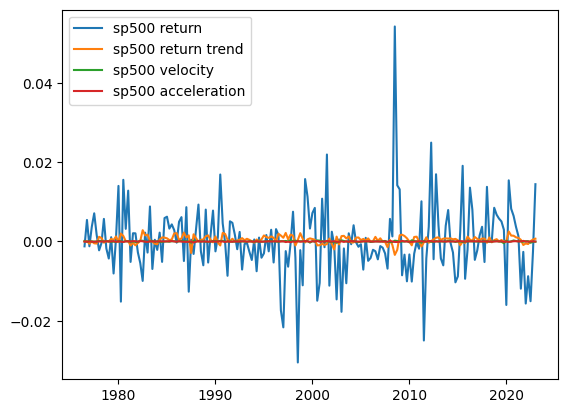

In [33]:
#sp500
plt.plot(data["date"], data[['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration']], label=['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration'])
plt.legend()

Plot of the INDU (Dow Jones?) return data (return, trend, velocity, and acceleration.)

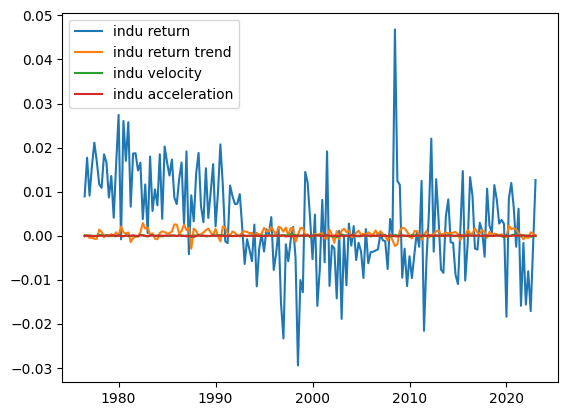

In [36]:
plt.plot(data["date"], data[['indu return', 'indu return trend',
       'indu velocity', 'indu acceleration']], label=['indu return', 'indu return trend',
       'indu velocity', 'indu acceleration'])
plt.legend()



PLot of WPSID62 (?) data (trend, velocity, and acceleration.)

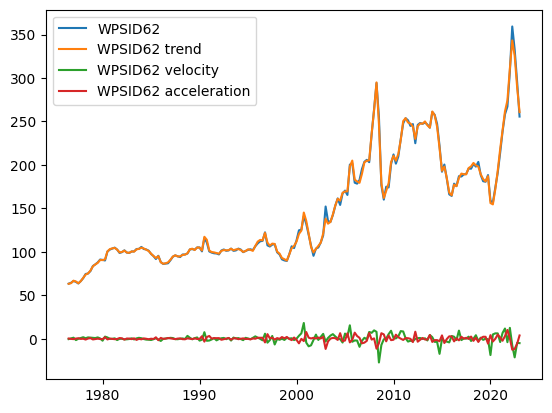

In [39]:
plt.plot(data["date"], data[['WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration']], label=['WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration'])
plt.legend()


Plot of yield curve data (yield curve, trend, velocity, and acceleration.)

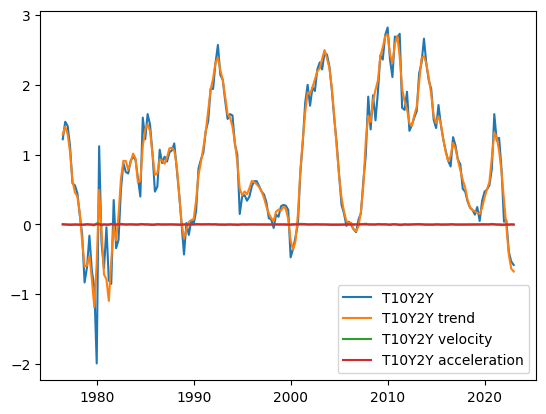

In [40]:
plt.plot(data["date"], data[['T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration']], label=['T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration'])
plt.legend()

PLot of real GDP. Note the massive dip in 2020. This is a problem when we run Granger Causality tests later.

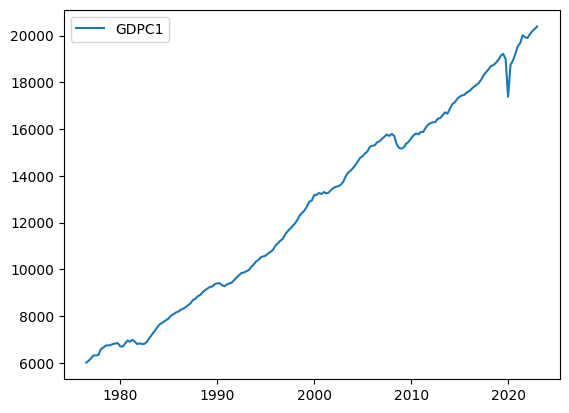

In [41]:
plt.plot(data["date"], data['GDPC1'], label='GDPC1')
plt.legend()

In [17]:
dataM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Quarter                    145 non-null    object        
 1   Avg. M-Score               145 non-null    float64       
 2   Weighted_M                 145 non-null    float64       
 3   Count                      145 non-null    float64       
 4   sp500 return               145 non-null    float64       
 5   sp500 return trend         145 non-null    float64       
 6   sp500 velocity             145 non-null    float64       
 7   sp500 acceleration         145 non-null    float64       
 8   indu return                145 non-null    float64       
 9   indu return trend          145 non-null    float64       
 10  indu velocity              145 non-null    float64       
 11  indu acceleration          145 non-null    float64       
 12  GDPC1   

In [42]:
dataM.columns

Index(['Quarter', 'Avg. M-Score', 'Weighted_M', 'Count', 'sp500 return',
       'sp500 return trend', 'sp500 velocity', 'sp500 acceleration',
       'indu return', 'indu return trend', 'indu velocity',
       'indu acceleration', 'GDPC1', 'WPSID62', 'WPSID62 trend',
       'WPSID62 velocity', 'WPSID62 acceleration', 'T10Y2Y', 'T10Y2Y trend',
       'T10Y2Y velocity', 'T10Y2Y acceleration', 'average beta',
       'average MCAP', 'WAB', 'average beta trend', 'average MCAP trend',
       'WAB trend', 'average beta velocity', 'average beta acceleration',
       'average MCAP velocity', 'average MCAP acceleration', 'WAB velocity',
       'WAB acceleration', 'date'],
      dtype='object')

Plot of average and weighted average M-Score.

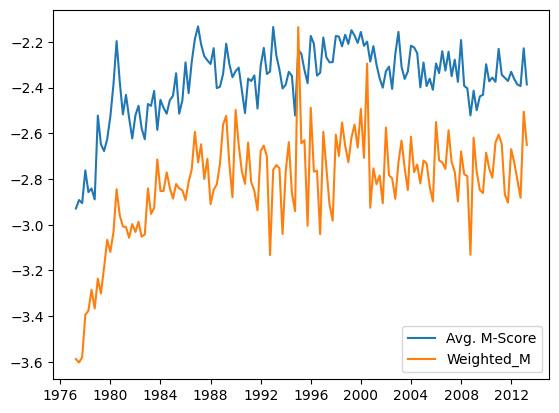

In [43]:
plt.plot(dataM["date"], dataM[['Avg. M-Score', 'Weighted_M']], label=['Avg. M-Score', 'Weighted_M'])
plt.legend()



Plot of average beta (beta, trend, velocity, and acceleration.)

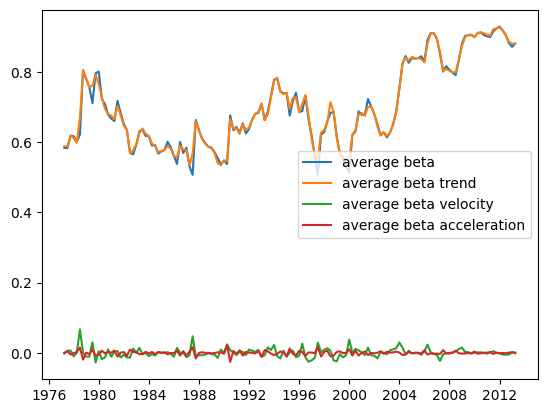

In [45]:
plt.plot(dataM["date"], dataM[['average beta','average beta trend','average beta velocity','average beta acceleration']], label=['average beta','average beta trend ','average beta velocity ','average beta acceleration'])
plt.legend()


Plot of weighted average beta (trend, velocity, and acceleration.)

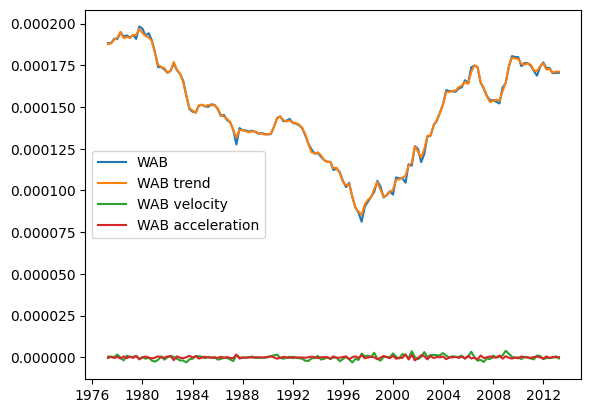

In [47]:
plt.plot(dataM["date"], dataM[['WAB','WAB trend','WAB velocity','WAB acceleration']], label=['WAB','WAB trend','WAB velocity ','WAB acceleration'])
plt.legend()


Plot of average market capitalization (trend, velocity, and acceleration.)

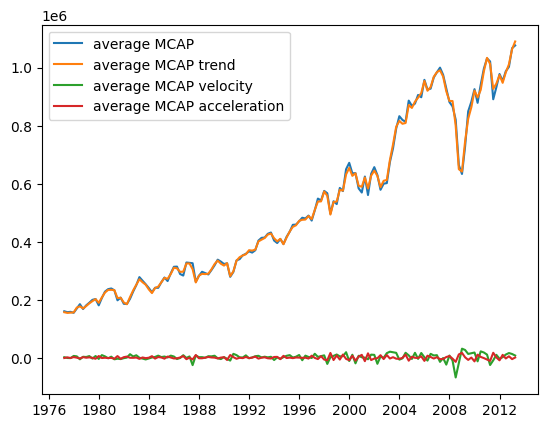

In [48]:
plt.plot(dataM["date"], dataM[['average MCAP','average MCAP trend','average MCAP velocity','average MCAP acceleration']], label=['average MCAP','average MCAP trend','average MCAP velocity','average MCAP acceleration'])
plt.legend()


In [22]:
data.columns

Index(['sp500 return', 'sp500 return trend', 'sp500 velocity',
       'sp500 acceleration', 'Quarter', 'indu return', 'indu return trend',
       'indu velocity', 'indu acceleration', 'GDPC1', 'WPSID62',
       'WPSID62 trend', 'WPSID62 velocity', 'WPSID62 acceleration', 'T10Y2Y',
       'T10Y2Y trend', 'T10Y2Y velocity', 'T10Y2Y acceleration', 'date'],
      dtype='object')

1) The below cells are running the Augmented Dickey-Fuller Test to check for stationary time series data. Granger Causality assumed that the data is stationary, so we need to make that true first

In [4]:
#ADF test for non-m-score data set
data_cols = data.loc[:,~data.columns.isin(["Quarter", "date"])].columns
data_adf = []
for i in data_cols:
    hold = adfuller(data[i])
    data_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_adf_df = pd.DataFrame(data_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

 In the 2023 data set, ndu return, GDPC1, WSPID62, WPSID62 trend, are all non-stationary, so they need to be differenced.

In [18]:
data_adf_df

,Column,Test Statistic,P-Value,Stationary?
0,sp500 return,-7.809705,7.123872e-12,True
1,sp500 return trend,-10.416515,1.748714e-18,True
2,sp500 velocity,-13.387918,4.831638e-25,True
3,sp500 acceleration,-13.587683,2.065296e-25,True
4,indu return,-2.435610,1.319368e-01,False
5,indu return trend,-10.729889,2.998611e-19,True
6,indu velocity,-13.754516,1.035629e-25,True
7,indu acceleration,-13.527539,2.660480e-25,True
8,GDPC1,0.706894,9.899745e-01,False
9,WPSID62,-0.420540,9.066125e-01,False


In [5]:
#ADF test for non-m-score data set
dataM_cols = dataM.loc[:,~dataM.columns.isin(["Quarter", "date", "Count"])].columns
dataM_adf = []
for i in dataM_cols:
    hold = adfuller(dataM[i])
    dataM_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

dataM_adf_df = pd.DataFrame(dataM_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

In the 2013 data set, we have the same results plus average beta, average MCAP, WAB, average beta trend, average MCAP trend, WAB trend, and WAB velocity are also non-stationary. 

In [6]:
dataM_adf_df

,Column,Test Statistic,P-Value,Stationary?
0,Avg. M-Score,-3.832920,2.587904e-03,True
1,Weighted_M,-4.288413,4.651886e-04,True
2,sp500 return,-6.838989,1.811549e-09,True
3,sp500 return trend,-9.295537,1.148854e-15,True
4,sp500 velocity,-8.117409,1.180768e-12,True
5,sp500 acceleration,-12.376055,5.152632e-23,True
6,indu return,-2.228239,1.961564e-01,False
7,indu return trend,-9.649193,1.450072e-16,True
8,indu velocity,-11.927967,4.856454e-22,True
9,indu acceleration,-12.121411,1.821657e-22,True


Need to difference the non-stationary data to try to make them stationary. Differencing takes the difference with the previous row, or t-1. I first only looked at the columns that needed differencing.

In [25]:
list(data_adf_df[data_adf_df["Stationary?"] == False].Column)

['indu return', 'GDPC1', 'WPSID62', 'WPSID62 trend']

In [7]:
data_non_stat = data.loc[:,list(data_adf_df[data_adf_df["Stationary?"] == False].Column)]
dataM_non_stat = dataM.loc[:,list(dataM_adf_df[dataM_adf_df["Stationary?"] == False].Column)]

data_non_stat_trans = data_non_stat.diff().dropna()
dataM_non_stat_trans = dataM_non_stat.diff().dropna()

data_adf_trans = []
for i in data_non_stat_trans.columns:
    hold = adfuller(data_non_stat_trans[i])
    data_adf_trans.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_adf_trans_df = pd.DataFrame(data_adf_trans, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])


dataM_adf_trans = []
for i in dataM_non_stat_trans:
    hold = adfuller(dataM_non_stat_trans[i])
    dataM_adf_trans.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

dataM_adf_trans_df = pd.DataFrame(dataM_adf_trans, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

After differencing the data, everything is stationary.

In [8]:
display(data_adf_trans_df)
display(dataM_adf_trans_df)

,Column,Test Statistic,P-Value,Stationary?
0,indu return,-6.458333,1.464343e-08,True
1,GDPC1,-16.325114,3.100085e-29,True
2,WPSID62,-3.900012,2.034759e-03,True
3,WPSID62 trend,-3.991740,1.454385e-03,True


,Column,Test Statistic,P-Value,Stationary?
0,indu return,-8.774545,2.469083e-14,True
1,GDPC1,-5.531577,1.782612e-06,True
2,WPSID62,-3.243858,1.758228e-02,True
3,WPSID62 trend,-3.555332,6.674698e-03,True
4,average beta,-11.871818,6.476740e-22,True
5,average MCAP,-10.702339,3.497377e-19,True
6,WAB,-6.582292,7.462010e-09,True
7,average beta trend,-9.353411,8.179873e-16,True
8,average MCAP trend,-8.296953,4.115497e-13,True
9,WAB trend,-7.503597,4.190806e-11,True


From what I can tell, I need to diff the entire data in order to be consistent, and only then can I do granger causality. I created data frames data_diff and dataM_diff that hold the differenced data and then ran the test again, ending up with stationary data.

In [9]:

data_diff = data.drop(columns=["Quarter", "date"], axis=1).diff().dropna()
dataM_diff = dataM.drop(columns=["Quarter", "Count", "date"], axis=1).diff().dropna()

data_diff_adf = []
for i in data_cols:
    hold = adfuller(data_diff[i])
    data_diff_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_diff_adf_df = pd.DataFrame(data_diff_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])


dataM_diff_adf = []
for i in dataM_cols:
    hold = adfuller(dataM_diff[i])
    dataM_diff_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

dataM_diff_adf_df = pd.DataFrame(dataM_diff_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])

display(data_diff_adf_df)
display(dataM_diff_adf_df)

,Column,Test Statistic,P-Value,Stationary?
0,sp500 return,-7.109053,3.982983e-10,True
1,sp500 return trend,-7.260385,1.687588e-10,True
2,sp500 velocity,-7.483142,4.714311e-11,True
3,sp500 acceleration,-6.715947,3.581873e-09,True
4,indu return,-6.458333,1.464343e-08,True
5,indu return trend,-6.512309,1.092700e-08,True
6,indu velocity,-7.368797,9.086527e-11,True
7,indu acceleration,-6.474810,1.339334e-08,True
8,GDPC1,-16.325114,3.100085e-29,True
9,WPSID62,-3.900012,2.034759e-03,True


,Column,Test Statistic,P-Value,Stationary?
0,Avg. M-Score,-4.934464,2.986940e-05,True
1,Weighted_M,-6.591185,7.107928e-09,True
2,sp500 return,-5.822276,4.156181e-07,True
3,sp500 return trend,-7.456816,5.484675e-11,True
4,sp500 velocity,-6.878334,1.455036e-09,True
5,sp500 acceleration,-5.682389,8.428006e-07,True
6,indu return,-8.774545,2.469083e-14,True
7,indu return trend,-6.716516,3.570640e-09,True
8,indu velocity,-6.561509,8.358722e-09,True
9,indu acceleration,-5.350613,4.297562e-06,True


2) Kerstin's attempt at testing Causation with Granger's Causality Test. The tests tests the null hypothesis that the coefficients of past values in the regression equation is zero (or that past values of the data do not cause the other series). We want to find the factors that DO cause GDP, therefore that have a p-value less than 0.05 or any other alpha.

In [25]:

def grangers_causation_matrix(data1, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of each variables against GDP.
    The resulting columns are the predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data1      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((1, len(variables))), columns=variables, index=["GDPC1"]) #only need to seewhat variables lag GDP
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data1[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var  for var in variables]
    df.index = ['GDPC1']
    return df

#grangers_causation_matrix(df, variables = df.columns)  

In [38]:
data_diff.head()

,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,indu return,indu return trend,indu velocity,indu acceleration,GDPC1,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,T10Y2Y acceleration
1,0.006660,0.000078,-0.000177,-0.000036,0.008777,0.000344,-1.680028e-04,0.000004,71.035,1.1,0.733333,0.75,-0.425,0.25,0.110250,-0.003750,0.000094
2,-0.006644,-0.000660,0.000152,0.000067,-0.008609,-0.000682,1.166528e-04,0.000019,118.268,2.1,2.800000,0.85,-0.250,-0.06,-0.106875,-0.003292,0.000281
3,0.004914,0.000589,-0.000089,-0.000055,0.006648,0.000078,-8.805833e-05,-0.000051,111.900,-1.1,-0.933333,-2.75,0.625,-0.29,-0.256250,-0.005021,0.000021
4,0.003398,-0.000490,-0.000018,-0.000049,0.005384,-0.000278,1.444444e-07,-0.000050,0.138,-1.8,-2.066667,1.50,0.375,-0.53,-0.409125,0.001937,0.000271
5,-0.005409,-0.000058,-0.000013,0.000082,-0.004233,0.000009,-4.569444e-05,0.000098,20.151,2.7,2.500000,0.90,-0.775,-0.03,-0.166083,0.004354,-0.000417


We run Granger Causality on the DIFFERENCED data, not the initial data because the test assumes that the data is stationary. I chose maxlag=12 because it would cover a 3 year lag (our data is quarterly).

In [39]:
#running granger causality on the data (2023) and dataM df
#first use lag of 12, aka 3 years
maxlag=12
data_granger = grangers_causation_matrix(data_diff, variables=data_diff.columns)
dataM_granger = grangers_causation_matrix(dataM_diff, variables=dataM_diff.columns)

C:\Users\Kerstin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


C:\Users\Kerstin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Kerstin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Kerstin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
C:\Users\Kerstin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarni

In [60]:

print("Granger Causality results for the 2013 data.\n")
display(dataM_granger) # <= 0.05
print("Granger Causality results for the 2023 data.")
display(data_granger) #<= 0.05

Granger Causality results for the 2013 data.



,Avg. M-Score,Weighted_M,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,indu return,indu return trend,indu velocity,indu acceleration,...,WAB,average beta trend,average MCAP trend,WAB trend,average beta velocity,average beta acceleration,average MCAP velocity,average MCAP acceleration,WAB velocity,WAB acceleration
GDPC1,0.0332,0.0724,0.1304,0.027,0.0618,0.2158,0.099,0.0081,0.033,0.4032,...,0.0001,0.6609,0.0977,0.0007,0.0758,0.521,0.0132,0.0935,0.0003,0.0001


Granger Causality results for the 2023 data.


,sp500 return,sp500 return trend,sp500 velocity,sp500 acceleration,indu return,indu return trend,indu velocity,indu acceleration,GDPC1,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,T10Y2Y acceleration
GDPC1,0.3802,0.1824,0.0005,0.0945,0.3135,0.2492,0.0007,0.0587,1.0,0.4894,0.629,0.5578,0.1515,0.6439,0.498,0.2056,0.0289


Remember we have two data sets, one that runs until 2023 and one that stops at 2013 (because the M-Score data isn't this far up to date). The 2023 data set only has three variables that lag GDP, while the 2013 data set has 16. I suspect that having the very recent data throws things off, becase there was a completely unpredictable recession in 2020 when the GDP dropped sharply. Since we include all that data from that recession, I think the test is assuming that since a variable did not predict that one, it must not predict any change in GDP. I think we should try again with data restricted to 2019 at the very latest.

In [41]:
display(data_granger[data_granger <= 0.05].dropna(axis=1))
display(dataM_granger[dataM_granger <= 0.05].dropna(axis=1))

,sp500 velocity,indu velocity,T10Y2Y acceleration
GDPC1,0.0005,0.0007,0.0289


,Avg. M-Score,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
GDPC1,0.0332,0.027,0.0081,0.033,0.0,0.0,0.0002,0.0,0.0063,0.0347,0.0078,0.0001,0.0007,0.0132,0.0003,0.0001


Here I reduced created a data frame that has all data before 2020. The first ADF test revealed some non-stationary variables so I differenced the data and then ran it again to a 100% success rate.

In [50]:
data_red = data.loc[data.date < "2020"]

#ADF test for non-m-score data set
#data_cols = data.loc[:,~data.columns.isin(["Quarter", "date"])].columns
data_red_adf = []
for i in data_cols:
    hold = adfuller(data_red[i])
    data_red_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_red_adf_df = pd.DataFrame(data_red_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])
#data_red_adf_df
data_red_diff = data_red.drop(columns=["Quarter", "date"], axis=1).diff().dropna()

data_red_diff_adf = []
for i in data_cols:
    hold = adfuller(data_red_diff[i])
    data_red_diff_adf.append([i, hold[0], hold[1], hold[1] < 0.05]) #if p value is less than 0.05, we reject and therefore the time series is stationary

data_red_diff_adf_df = pd.DataFrame(data_red_diff_adf, columns=["Column", "Test Statistic", "P-Value", "Stationary?"])
data_red_diff_adf_df



,Column,Test Statistic,P-Value,Stationary?
0,sp500 return,-6.593043,7.036081e-09,True
1,sp500 return trend,-6.869072,1.532150e-09,True
2,sp500 velocity,-7.192105,2.488226e-10,True
3,sp500 acceleration,-6.469292,1.379983e-08,True
4,indu return,-6.070461,1.154192e-07,True
5,indu return trend,-7.306225,1.299405e-10,True
6,indu velocity,-6.935038,1.059978e-09,True
7,indu acceleration,-6.134826,8.235167e-08,True
8,GDPC1,-8.482650,1.379793e-13,True
9,WPSID62,-3.524216,7.386534e-03,True


I then ran the Granger's Causality algorithm again, revealing a larger numer of varaibles that lag GDP.

In [ ]:
data_red_granger = grangers_causation_matrix(data_red_diff, variables=data_red_diff.columns)

In [61]:
print("Non-M-Score data up to 2019 \n")
display(data_red_granger[data_red_granger <= 0.05].dropna(axis=1))
print("Non-M-Score data up to 2023 \n")
display(data_granger[data_granger <= 0.05].dropna(axis=1))
print("M-Score data up to 2013 \n")
display(dataM_granger[dataM_granger <= 0.05].dropna(axis=1))

Non-M-Score data up to 2019 



,sp500 return trend,indu return trend,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y velocity
GDPC1,0.0395,0.0273,0.0072,0.0041,0.0289,0.0217,0.0494,0.0261


Non-M-Score data up to 2023 



,sp500 velocity,indu velocity,T10Y2Y acceleration
GDPC1,0.0005,0.0007,0.0289


M-Score data up to 2013 



,Avg. M-Score,sp500 return trend,indu return trend,indu velocity,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,WAB,WAB trend,average MCAP velocity,WAB velocity,WAB acceleration
GDPC1,0.0332,0.027,0.0081,0.033,0.0,0.0,0.0002,0.0,0.0063,0.0347,0.0078,0.0001,0.0007,0.0132,0.0003,0.0001


As I thought, we have more variables that lag GDP when we restrict our data to being before 2020. In fact, all the variables are also present in the data set that include M-Score, WAB, and MCAP. I really believe we should proceed with the data set that is restricted to 2013. It has all the variables that we would want to look at anyways and that way we don't need to worry about choosing the time point to restrict the data at.